In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.callbacks import * 
from keras.applications import ResNet50
from keras.metrics import MeanIoU
from keras.models import load_model


In [8]:
COLOR_MODE = 'rgb'
INPUT_SIZE = (256,256)

In [9]:
car = cv.imread('car-segmentation\\images\\003.png')
mask = cv.imread('car-segmentation\\masks\\003.png',0)

In [10]:
mask.shape

(368, 900)

# Mask:
####
0 -> Background

1 -> Car

2 -> Wheel

3 -> Lights

4 -> Window


In [11]:
mask_dict = {
    0 : 'Background',
    1 : 'Car',
    2 : 'Wheel',
    3 : 'Lights',
    4 : 'Window'
}

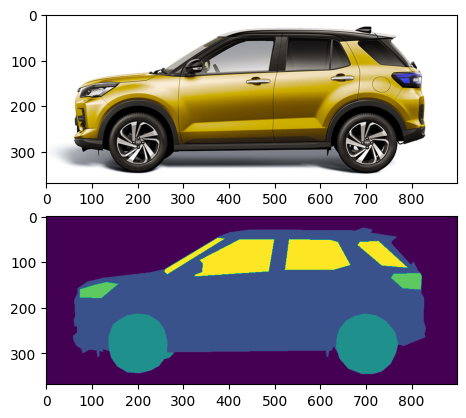

In [12]:
fig, ax = plt.subplots(2)
ax[0].imshow(car)
ax[1].imshow(mask)
plt.show()

In [13]:
def encode_mask(mask):
    return (np.arange(mask.max()+1) == mask[...,None]).astype(float)


In [14]:
mask2 = encode_mask(mask)
mask2.shape

(368, 900, 5)

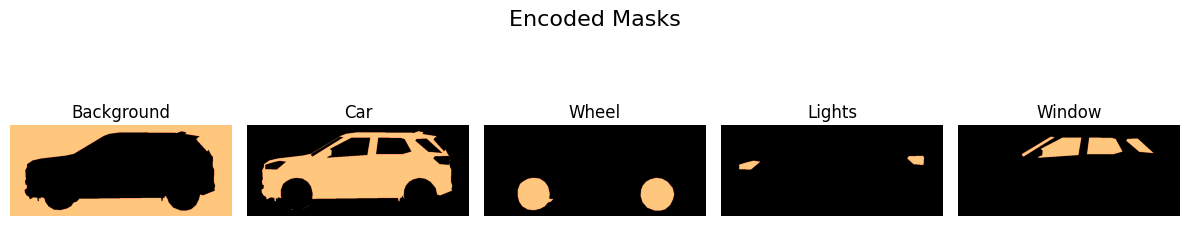

In [15]:
fig, ax = plt.subplots(1,5,figsize=(12, 3))
fig.suptitle('Encoded Masks', fontsize=16)
for id,_ in enumerate(ax):
    ax[id].imshow(mask2[:,:,id],cmap='copper')
    ax[id].set_title(mask_dict[id])
    ax[id].axis('off')

plt.tight_layout()
plt.show()

In [16]:
file_names = np.array([files for _, _, files in os.walk('car-segmentation\\images')][0])
file_names

array(['003.png', '105618339-super-purple-modern-suv-car-side-view.png',
       '105618639-modern-pale-blue-suv-car-side-view.png',
       '156551_preview.png', '178583_Side_Profile_Web.png',
       '1965-Shelby-Cobra-Roadster-Side-Profile.png',
       '2008-Morgan-Life-Car-Side-Speed-1024x768.png',
       '2009-Ford-Kuga-Show-Car-Side-1280x960.png',
       '2011-278656-pagani-huayra-side-view1.png',
       '2015_aston_martin_db10_4.png',
       '2018-bm4-gt4-sports-car-side-view-pk.png',
       '2018-nissan-sentra-2017-nissan-sentra-car-nissan-micra-png-f.png',
       '2019-acura-rdx-11.png',
       '2019-ferrari-488-spider-side-view-carbuzz-669506.png',
       '202-2028012_car-png-hd-side-view-transparent-png.png',
       '2020-Honda-City-7-1068x672.png',
       '39839516-black-sedan-car-side-view.png',
       '3d_metal_machine_160_2000x.png',
       '45303-Kit-stickers-bandes-Mitsubishi-L200.png',
       '47865-Kit-Bandes-Bas-Caisse-Porsche-Boxster.png',
       '62271369-ehrf%C3%BCr

# Data Split

In [17]:
data = np.copy(file_names)
np.random.shuffle(data)
train_test_split = int(0.7 * len(data))
train_filenames = data[:train_test_split]
test_filenames = data[train_test_split:]

# Model

In [86]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, classes,dropout=0):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)

    b1 = conv_block(p5, 2048) #Bridge

    d0 = decoder_block(b1, s5, 1024)
    d1 = decoder_block(d0, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    x = Dropout(dropout)(d4)
    outputs = Conv2D(classes, 1, padding="same", activation="sigmoid")(x)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    model.summary()
    return model

In [87]:
def decoder_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def resnet50_unet(input_shape, *, classes, dropout):
    """ Input """
    inputs = Input(input_shape,name='input_1')

    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output          
    s2 = resnet50.get_layer("conv1_relu").output       
    s3 = resnet50.get_layer("conv2_block3_out").output 
    s4 = resnet50.get_layer("conv3_block4_out").output  

    x = resnet50.get_layer("conv4_block6_out").output  

    """ Decoder """
    x = decoder_block(x, s4, 512)                     
    x = decoder_block(x, s3, 256)                    
    x = decoder_block(x, s2, 128)                    
    x = decoder_block(x, s1, 64)                      

    x = Dropout(dropout)(x)
    outputs = Conv2D(classes, 1, activation="softmax")(x)
    model = Model(inputs, outputs, name="ResNet50_U-Net")
    model.summary()
    return model

# Data Generator

In [88]:
class DataGenerator(Sequence):
    def __init__(self,filenames,input_size,batch_size,color_mode,classes,ratio=1):
        self.filenames = np.copy(filenames)
        np.random.shuffle(self.filenames)
        self.input_size = input_size
        self.batch_size = batch_size
        self.color_mode = color_mode
        self.classes = classes
        self.ratio = ratio
        self.color_channels = 1 if self.color_mode == 'gray' else 3


    def __len__(self):
        return int(np.floor((len(self.filenames)*self.ratio) / self.batch_size))
        
    def __getitem__(self, index):
        batchfiles = self.filenames[index * self.batch_size : (index+1)*self.batch_size]
        X,Y = self.get_data(batchfiles)
        return X,Y

    def encode_mask(self,mask):
        return (np.arange(mask.max()+1) == mask[...,None]).astype(float)

    
    def get_data(self, batchfiles):
        color_dict={
            'hsv': cv.COLOR_BGR2HSV,
            'rgb': cv.COLOR_BGR2RGB,
            'gray': cv.COLOR_BGR2GRAY
        }
        X = np.empty(shape=(self.batch_size, *self.input_size, 3))
        Y = np.empty(shape=(self.batch_size, *self.input_size, 1))
        for i,file in enumerate(batchfiles):
            img = cv.imread(os.path.join('car-segmentation\\images', file))
            mask = cv.imread(os.path.join('car-segmentation\\masks', file),0)
            #img,mask = self.random_transformation(img,mask)
            
            img = cv.cvtColor(img, color_dict[self.color_mode])
            if self.color_mode == 'gray':
                img = np.repeat(img[..., np.newaxis], 3, -1)
            img = cv.resize(img, self.input_size)
            img = tf.cast(img, tf.float32)
            img /= 255.

            
            mask = cv.resize(mask, self.input_size)
            #mask = self.encode_mask(mask)
            #mask = tf.cast(mask, tf.float32)
            X[i] = img
            Y[i] = mask.reshape(*self.input_size, 1)
        
        return X,Y

    def random_transformation(self, img, mask):
        angle = random.randint(-30,30)
        img = self.rotate_image(img,angle)
        mask = self.rotate_image(mask,angle)
        flip = random.randint(0,3)
        if flip > 0:
            img = cv.flip(img,flip-2)
            mask = cv.flip(mask,flip-2)
        alpha = random.random() * 2 -1
        beta = random.random() * 3 - 1.5
        img = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
        return img,mask
    
    def rotate_image(self, image, angle):
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
        result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
        return result


# Metrics

In [18]:
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)        
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

# Training the model

In [90]:
input_size = (*INPUT_SIZE,3)
unet = resnet50_unet(input_size, classes= 5, dropout= 0.3)

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [91]:
checkpoint =[
                ModelCheckpoint('resunet.h5', monitor= 'val_mean_iou', save_best_only= True,mode='max'),\
                EarlyStopping(patience=10, monitor= 'val_mean_iou', restore_best_weights=True,mode='max',start_from_epoch=60),\
                ReduceLROnPlateau(monitor= 'loss', patience=5, factor= 0.3, min_lr=10**-7, verbose=1)
            ]

m = m_iou(5)

unet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
            optimizer =tf.keras.optimizers.Adam(learning_rate=10**-5),\
            metrics= ['accuracy',m.mean_iou],\
            run_eagerly=True)


train_val_split = int(len(train_filenames)*0.8)
trainGen = DataGenerator(train_filenames[:train_val_split],INPUT_SIZE,8,COLOR_MODE,5)
valGen = DataGenerator(train_filenames[train_val_split:],INPUT_SIZE,8,COLOR_MODE,5)

history = unet.fit(x=trainGen, validation_data=valGen, epochs= 150, verbose=1, callbacks = checkpoint)

Epoch 1/150
14/14 [==============================] - 86s 6s/step - loss: 1.1807 - accuracy: 0.5796 - mean_iou: 0.2571 - val_loss: 1.6738 - val_accuracy: 0.2909 - val_mean_iou: 0.0818 - lr: 1.0000e-05
Epoch 2/150
14/14 [==============================] - 84s 6s/step - loss: 0.7121 - accuracy: 0.7839 - mean_iou: 0.4392 - val_loss: 1.8077 - val_accuracy: 0.2972 - val_mean_iou: 0.0788 - lr: 1.0000e-05
Epoch 3/150
14/14 [==============================] - 85s 6s/step - loss: 0.5287 - accuracy: 0.8637 - mean_iou: 0.5302 - val_loss: 1.8377 - val_accuracy: 0.3264 - val_mean_iou: 0.0874 - lr: 1.0000e-05
Epoch 4/150
14/14 [==============================] - 85s 6s/step - loss: 0.4251 - accuracy: 0.9013 - mean_iou: 0.5793 - val_loss: 1.7306 - val_accuracy: 0.3556 - val_mean_iou: 0.1139 - lr: 1.0000e-05
Epoch 5/150
14/14 [==============================] - 84s 6s/step - loss: 0.3574 - accuracy: 0.9221 - mean_iou: 0.6121 - val_loss: 1.6614 - val_accuracy: 0.2991 - val_mean_iou: 0.0957 - lr: 1.0000e-05


In [1]:
fig, axes = plt.subplots(3, figsize= (20,5))
# Train
axes[0].plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
axes[0].plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
axes[1].plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean IOU')
axes[1].legend()
axes[2].plot(history.epoch, history.history['accuracy'], color= 'r',  label = 'Train')
axes[2].plot(history.epoch, history.history['val_accuracy'], color = 'b', label = 'Val')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
plt.show()

NameError: name 'plt' is not defined

# Example

In [27]:
def showExample(ex):
    m = m_iou(5)
    model = load_model('resunet.h5',custom_objects = {'mean_iou': m.mean_iou})
    color_dict={
            'hsv': cv.COLOR_BGR2HSV,
            'rgb': cv.COLOR_BGR2RGB,
            'gray': cv.COLOR_BGR2GRAY
        }
    fig, axs = plt.subplots(2,2,figsize=(6, 6))
    img = cv.imread(os.path.join('car-segmentation\\images', ex))
    axs[0,0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    axs[0,0].set_title('Original Image')
    axs[0,0].axis('off')
    a,b, *_ = img.shape
    
    img = cv.cvtColor(img, color_dict[COLOR_MODE])
    img = cv.resize(img, INPUT_SIZE)
    if COLOR_MODE == 'gray':
        img = np.repeat(img[..., np.newaxis], 3, -1)
    img = tf.cast(img, tf.float32)
    img /= 255.
    axs[0,1].imshow(img,cmap='binary')
    axs[0,1].set_title('Image Fed to the Model')
    axs[0,1].axis('off')

    og_mask = cv.imread(os.path.join('car-segmentation\\masks', ex),0)
    axs[1,0].imshow(og_mask)
    axs[1,0].set_title('Original Mask')
    axs[1,0].axis('off')
    
    pred = model.predict(np.array([img]))[0]
    pred = cv.resize(pred.astype(float),(b,a))
    pred2 = np.argmax(pred,axis=2)
    
    axs[1,1].imshow(pred2)
    axs[1,1].set_title('Predicted Mask')
    axs[1,1].axis('off')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,5,figsize=(12, 3))
    fig.suptitle('Encoded Masks', fontsize=16)
    for id,_ in enumerate(ax):
        ax[id].imshow(np.where(pred[:,:,id] > 0.5, 1,0),cmap='binary')
        ax[id].set_title(mask_dict[id])
        ax[id].axis('off')
    plt.tight_layout()
    plt.show()
    
    
    

1/1 [==============================] - 1s 531ms/step


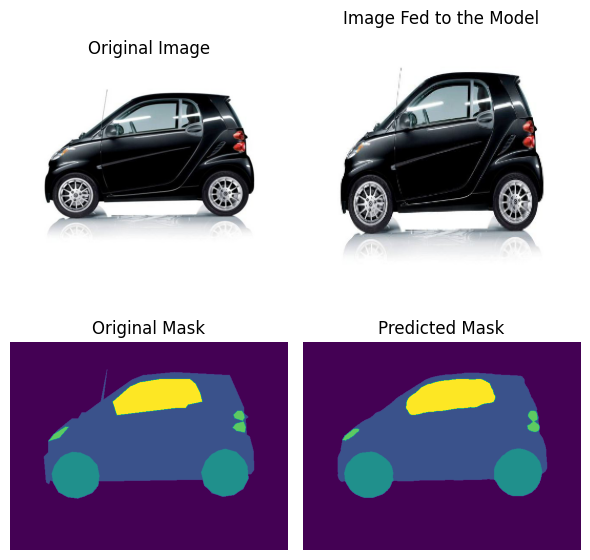

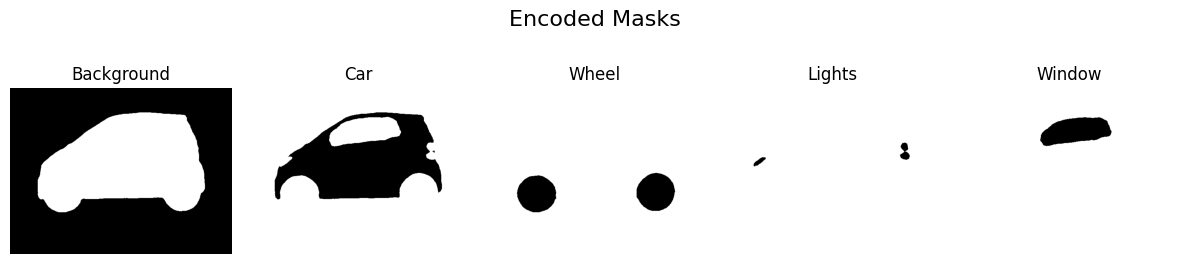

In [32]:
showExample(test_filenames[random.randint(0,len(test_filenames))])